# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [2]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

import numpy as np
import scipy.io as sio

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    mat = sio.loadmat(file_path)
    data = {
        'signal': mat['Signal'].squeeze(),
        'flashing': mat['Flashing'].squeeze(),
        'stimulus_code': mat['StimulusCode'].squeeze()
    }

    # Training data has labels, test data doesn't
    if 'StimulusType' in mat:
        data['stimulus_type'] = mat['StimulusType'].squeeze()
    else:
        data['stimulus_type'] = None

    # Fix for TargetChar: convert numeric codes or bytes to string
    if 'TargetChar' in mat:
        target = mat['TargetChar'].squeeze()
        # If already string-like
        if target.dtype.kind in {'U', 'S'}:
            data['target_char'] = ''.join(target.tolist())
        else:
            # Convert numeric codes to characters
            data['target_char'] = ''.join([chr(int(x)) for x in target])
    else:
        data['target_char'] = None

    return data

def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    return CHAR_MATRIX[row_code - 1, col_code - 7]


In [4]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq=0.5*fs
    low=lowcut/nyq
    high=highcut/nyq
    b,a=butter(order,[low,high],btype='band')
    return filtfilt(b,a,signal,axis=0)


def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    b,a=iirnotch(freq/(fs/2),Q)
    return filtfilt(b,a,signal,axis=0)


def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline=np.mean(epoch[:baseline_samples,:],axis=0)
    return epoch-baseline


def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor=original_fs//target_fs
    return signal[::factor,:]


def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    return signal


def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """
    signal=data['signal']
    if apply_bandpass:
        signal=bandpass_filter(signal,fs=fs)
    if apply_notch:
        signal=notch_filter(signal,fs=fs)
    if apply_downsample:
        signal=downsample_signal(signal,original_fs=fs,target_fs=60)
        fs=60
    data['signal']=signal
    data['fs']=fs
    return data


def extract_epochs(data, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """
    signal=data['signal']
    flashing=data['flashing']
    stimulus_code=data['stimulus_code']
    stimulus_type=data['stimulus_type']

    samples_per_epoch=int(epoch_length_ms*fs/1000)
    baseline_samples=int(0.2*fs)

    epochs=[]
    labels=[]
    codes_list=[]
    char_idx_list=[]

        # Loop over trials
    for trial_idx in range(signal.shape[0]):
        f=np.rint(flashing[trial_idx]).astype(int)
        c=stimulus_code[trial_idx].astype(int)
        if stimulus_type is not None:
            st=stimulus_type[trial_idx]
        else:
            st=None

        # Find stimulus onsets (flashing goes from 0 to 1)
        onsets=np.where((f[1:]==1)&(f[:-1]==0))[0]+1

        for idx in onsets:
            if idx-baseline_samples<0 or idx+samples_per_epoch>signal.shape[1]:
                continue
            epoch=signal[trial_idx,idx:idx+samples_per_epoch,:]

                # Apply baseline correction
            baseline=np.mean(signal[trial_idx,idx-baseline_samples:idx,:],axis=0)
            epoch=epoch-baseline

            epochs.append(epoch)
            codes_list.append(c[idx])
            labels.append(st[idx] if st is not None else None)
            char_idx_list.append((trial_idx,idx))

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs=np.array(epoch_data['epochs'])
    labels=np.array(epoch_data['labels'])

    target_epochs=epochs[labels==1,:,channel_idx]
    nontarget_epochs=epochs[labels==0,:,channel_idx]

    t=np.arange(epochs.shape[1])/fs*1000

    mean_t=np.mean(target_epochs,axis=0)
    mean_nt=np.mean(nontarget_epochs,axis=0)

    # Plot averages with standard error
    plt.figure(figsize=(8,4))
    plt.plot(t,mean_t,label='Target')
    plt.plot(t,mean_nt,label='Non-Target')
    plt.xlabel('Time(ms)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Mark P300 peak region
    plt.axvspan(250,450,alpha=0.2)

    plt.show()

    # Calculate P300 amplitude difference
    return np.max(mean_t[15:30])-np.max(mean_nt[15:30])


In [5]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    n_epochs,n_samples,n_channels=epochs.shape
    return epochs.reshape(n_epochs,n_samples*n_channels)

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    X=extract_time_domain_features(epochs)
    scaler=StandardScaler()
    X=scaler.fit_transform(X)
    pca=PCA(n_components=n_components)
    X_pca=pca.fit_transform(X)
    return X_pca,pca,scaler


def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs=epochs[labels==1]
    non_target_epochs=epochs[labels==0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
        cov=np.zeros((data.shape[2],data.shape[2]))
        for ep in data:
            ep=ep-np.mean(ep,axis=0)
            cov+=ep.T@ep/np.trace(ep.T@ep)
        return cov/len(data)

    cov_t=compute_cov(target_epochs)
    cov_nt=compute_cov(non_target_epochs)

    # Solve generalized eigenvalue problem
    eigvals,eigvecs=eigh(cov_t,cov_t+cov_nt)

    # Sort by eigenvalues
    idx=np.argsort(eigvals)[::-1]
    eigvecs=eigvecs[:,idx]

    # Select most discriminative components (extreme eigenvalues)
    W=np.hstack([eigvecs[:,:n_components//2],
                 eigvecs[:,-n_components//2:]])

    # Extract CSP features (log variance)
    features=[]
    for ep in epochs:
        Z=ep@W
        var=np.var(Z,axis=0)
        features.append(np.log(var/np.sum(var)))
    return np.array(features),W


def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    epochs=np.array(epoch_data['epochs'])
    labels=np.array(epoch_data['labels'])

    if method=='time_domain':
        return extract_time_domain_features(epochs),None
    if method=='pca':
        return extract_pca_features(epochs,n_components)
    if method=='csp':
        return extract_csp_features(epochs,labels,n_components)

    raise ValueError("Unknown feature extraction method")


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """
    model=LinearDiscriminantAnalysis(priors=[0.5,0.5])
    model.fit(X_train,y_train)
    return model


def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    model=LogisticRegression(class_weight='balanced',max_iter=1000)
    model.fit(X_train,y_train)
    return model


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    print(f"\n{model_name} Results")
    print(classification_report(y_test,y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test,y_pred))

    metrics={
        'accuracy':accuracy_score(y_test,y_pred),
        'precision':precision_score(y_test,y_pred),
        'recall':recall_score(y_test,y_pred),
        'f1':f1_score(y_test,y_pred)
    }
    if y_prob is not None:
        metrics['roc_auc']=roc_auc_score(y_test,y_prob)
    return metrics


class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self,n_components=6):
        self.n_components=n_components
        self.W=None

    def fit(self,X,y):
        _,self.W=extract_csp_features(X,y,self.n_components)
        return self

    def transform(self,X):
        features=[]
        for ep in X:
            Z=ep@self.W
            var=np.var(Z,axis=0)
            features.append(np.log(var/np.sum(var)))
        return np.array(features)


In [6]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    model=SVC(kernel=kernel,C=C,class_weight='balanced',probability=True)
    model.fit(X_train,y_train)
    return model


def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    model=RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train,y_train)
    return model


def train_gradient_boosting(X_train, y_train, X_val=None, y_val=None):
    from sklearn.ensemble import GradientBoostingClassifier
    import numpy as np

    # Count samples per class
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)

    # Safeguards against zero counts
    if n_pos == 0 or n_neg == 0:

        sample_weight = np.ones(len(y_train))
    else:
        # balanced weights: inverse of class frequency
        w_pos = len(y_train) / (2.0 * n_pos)
        w_neg = len(y_train) / (2.0 * n_neg)
        sample_weight = np.array([w_pos if y == 1 else w_neg for y in y_train])

    # Train model
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train, sample_weight=sample_weight)

    # Optionally evaluate on validation set
    if X_val is not None and y_val is not None:
        val_acc = model.score(X_val, y_val)
        print(f"Validation accuracy: {val_acc:.4f}")

    return model



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """

    # Calculate sample weights once for methods that need it
    pos_weight=len(y_train)/(2*np.sum(y_train==1))
    neg_weight=len(y_train)/(2*np.sum(y_train==0))
    sample_weights=np.where(y_train==1,pos_weight,neg_weight)

    # Define models to train
    models={
        'LDA':train_lda_classifier(X_train,y_train),
        'LogReg':train_logistic_regression(X_train,y_train),
        'SVM':train_svm_classifier(X_train,y_train),
        'RandomForest':train_random_forest(X_train,y_train),
        'GradientBoosting':train_gradient_boosting(X_train,y_train)
    }

    results={}

        # Training
    for name,model in models.items():

        # Inference
        y_pred=model.predict(X_test)

        # Metrics
        results[name]={
            'accuracy':accuracy_score(y_test,y_pred),
            'precision':precision_score(y_test,y_pred),
            'recall':recall_score(y_test,y_pred),
            'f1':f1_score(y_test,y_pred)
        }

    # Summary table
    return results


def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model


In [7]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/EEG/BCI_Comp_III_Wads_2004/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Mounted at /content/drive


In [8]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [9]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---

--- Subject B ---



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


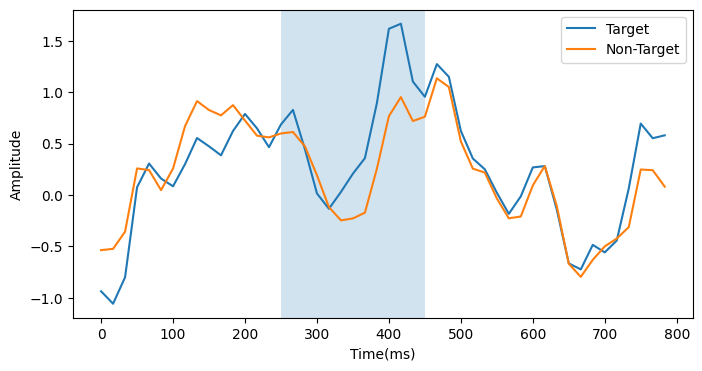

np.float64(0.5307561946394093)

In [10]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=31)

In [11]:
# ========================================================================
# STEP 5: FEATURE EXTRACTION
# ========================================================================
import numpy as np

print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

print("\n--- Subject A: Feature Comparison ---")

# Time-domain features
X_time_A = np.array(train_epochs_A['epochs']).reshape(len(train_epochs_A['epochs']), -1)
lda_time = train_lda_classifier(X_time_A, train_epochs_A['labels'])
metrics_time = evaluate_classifier(lda_time, X_time_A, train_epochs_A['labels'], model_name="LDA Time")
acc_time, f1_time = metrics_time['accuracy'], metrics_time['f1']

# PCA with 20 components
X_pca20_A, pca20_A, scaler20_A = extract_features(train_epochs_A, method='pca', n_components=20)
lda_pca20 = train_lda_classifier(X_pca20_A, train_epochs_A['labels'])
metrics_pca20 = evaluate_classifier(lda_pca20, X_pca20_A, train_epochs_A['labels'], model_name="LDA PCA-20")
acc_pca20, f1_pca20 = metrics_pca20['accuracy'], metrics_pca20['f1']

# PCA with 50 components
X_pca50_A, pca50_A, scaler50_A = extract_features(train_epochs_A, method='pca', n_components=50)
lda_pca50 = train_lda_classifier(X_pca50_A, train_epochs_A['labels'])
metrics_pca50 = evaluate_classifier(lda_pca50, X_pca50_A, train_epochs_A['labels'], model_name="LDA PCA-50")
acc_pca50, f1_pca50 = metrics_pca50['accuracy'], metrics_pca50['f1']

# CSP with 6 components
X_csp_A, csp_A = extract_features(train_epochs_A, method='csp', n_components=6)
lda_csp = train_lda_classifier(X_csp_A, train_epochs_A['labels'])
metrics_csp = evaluate_classifier(lda_csp, X_csp_A, train_epochs_A['labels'], model_name="LDA CSP")
acc_csp, f1_csp = metrics_csp['accuracy'], metrics_csp['f1']

# ========================================================================
print("\n" + "="*70)
print("FEATURE COMPARISON (Balanced Classifiers)")
print("="*70)
print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

# Select best method by F1-score
scores = {'time': f1_time, 'pca20': f1_pca20, 'pca50': f1_pca50, 'csp': f1_csp}
feature_method_A = max(scores, key=scores.get)

if feature_method_A == 'time':
    X_train_full_A = X_time_A
    feature_obj_A = None
elif feature_method_A == 'pca20':
    X_train_full_A = X_pca20_A
    feature_obj_A = (pca20_A, scaler20_A)
    n_components_A = 20
elif feature_method_A == 'pca50':
    X_train_full_A = X_pca50_A
    feature_obj_A = (pca50_A, scaler50_A)
    n_components_A = 50
else:  # CSP
    X_train_full_A = X_csp_A
    feature_obj_A = csp_A
    n_components_A = None

# ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================
X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data using stored transformers (no refit!)
if feature_method_A == 'time':
    X_test_A = np.array(test_epochs_A['epochs']).reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A.startswith('pca'):
    pca_obj, scaler_obj = feature_obj_A
    X_test_A = pca_obj.transform(scaler_obj.transform(
        np.array(test_epochs_A['epochs']).reshape(len(test_epochs_A['epochs']), -1)
    ))
else:  # CSP
    X_test_A = feature_obj_A.transform(np.array(test_epochs_A['epochs']))

print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

if feature_method_A == 'time':
    X_train_full_B = np.array(train_epochs_B['epochs']).reshape(len(train_epochs_B['epochs']), -1)
    X_test_B = np.array(test_epochs_B['epochs']).reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A.startswith('pca'):
    pca_obj, scaler_obj = feature_obj_A
    X_train_full_B, _, _ = extract_features(train_epochs_B, method='pca', n_components=n_components_A)
    X_test_B = pca_obj.transform(scaler_obj.transform(
        np.array(test_epochs_B['epochs']).reshape(len(test_epochs_B['epochs']), -1)
    ))
else:  # CSP
    X_train_full_B, csp_B = extract_features(train_epochs_B, method='csp', n_components=6)
    X_test_B = csp_B.transform(np.array(test_epochs_B['epochs']))

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")



STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---

LDA Time Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3283
         1.0       0.95      0.98      0.96       655

    accuracy                           0.99      3938
   macro avg       0.97      0.98      0.98      3938
weighted avg       0.99      0.99      0.99      3938

Confusion Matrix:
[[3249   34]
 [  15  640]]

LDA PCA-20 Results
              precision    recall  f1-score   support

         0.0       0.85      0.56      0.68      3283
         1.0       0.19      0.51      0.28       655

    accuracy                           0.55      3938
   macro avg       0.52      0.54      0.48      3938
weighted avg       0.74      0.55      0.61      3938

Confusion Matrix:
[[1840 1443]
 [ 320  335]]

LDA PCA-50 Results
              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70      3283
         1.0       0.2

In [12]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)

LDA Results
              precision    recall  f1-score   support

         0.0       0.81      0.58      0.68       657
         1.0       0.14      0.34      0.19       131

    accuracy                           0.54       788
   macro avg       0.48      0.46      0.44       788
weighted avg       0.70      0.54      0.60       788

Confusion Matrix:
[[380 277]
 [ 87  44]]

Logistic Regression Results
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.80       657
         1.0       0.16      0.23      0.19       131

    accuracy                           0.68       788
   macro avg       0.50      0.50      0.49       788
weighted avg       0.72      0.68      0.70       788

Confusion Matrix:
[[502 155]
 [101  30]]


In [ ]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)

    results_classical_A, models_A = compare_all_classical_models(
        X_train_A, y_train_A, X_val_A, y_val_A
    )

    # Train SVM for both subjects (best model)
    svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
    svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)


In [ ]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
        'pca': pca_A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
        'pca': pca_B
    }, 'models/subject_B_svm.pkl')

